In [1]:
from math import sqrt
from numpy import concatenate
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# set some default parameters
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['legend.fontsize']=12


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_dataset(city):
    for filename in os.listdir('processedData/'):
        if city in filename:
            df = pd.read_csv('processedData/' + filename,index_col=0)
    return df


def plotTimeseries(city):
    df = load_dataset(city)
    values = df.values
    # select numerical columns
    groups = [0, 1, 2, 3, 4, 6, 7, 8]
    i = 1
    fig = plt.figure(figsize=(12,20))
    fig.suptitle(f"Timeseries plots for {city} from 2011 to 2015", fontsize=16)
    # plot all columns
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.subplots_adjust(top=0.96)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.7, loc='right', fontsize=15)
        i += 1
    plt.show()
                                


In [68]:
from matplotlib.ticker import FuncFormatter
# Now let's reformat the y tickes to make show them in K and M.
def convert_large_nums(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '{:1.1f}M'.format(x*1e-6)
    elif x >= 1000:
        return '{:1.0f}K'.format(x*1e-3)
    else:
        return '{:1.0f}'.format(x)
formatter = FuncFormatter(convert_large_nums)
df = load_dataset('allcities').reset_index()
level0 = df.city.values
level1 = df.date.values

midx = pd.MultiIndex.from_arrays([level0, level1], names=['city', 'date'])
df.set_index(midx, inplace=True)
df.drop(['city','date'], axis=1, inplace=True)
df = df.unstack(level=0).reset_index()
df.columns=['date','Beijing','Chengdu','Guangzhou','Shanghai','Shenyang']
df.set_index('date',inplace=True)


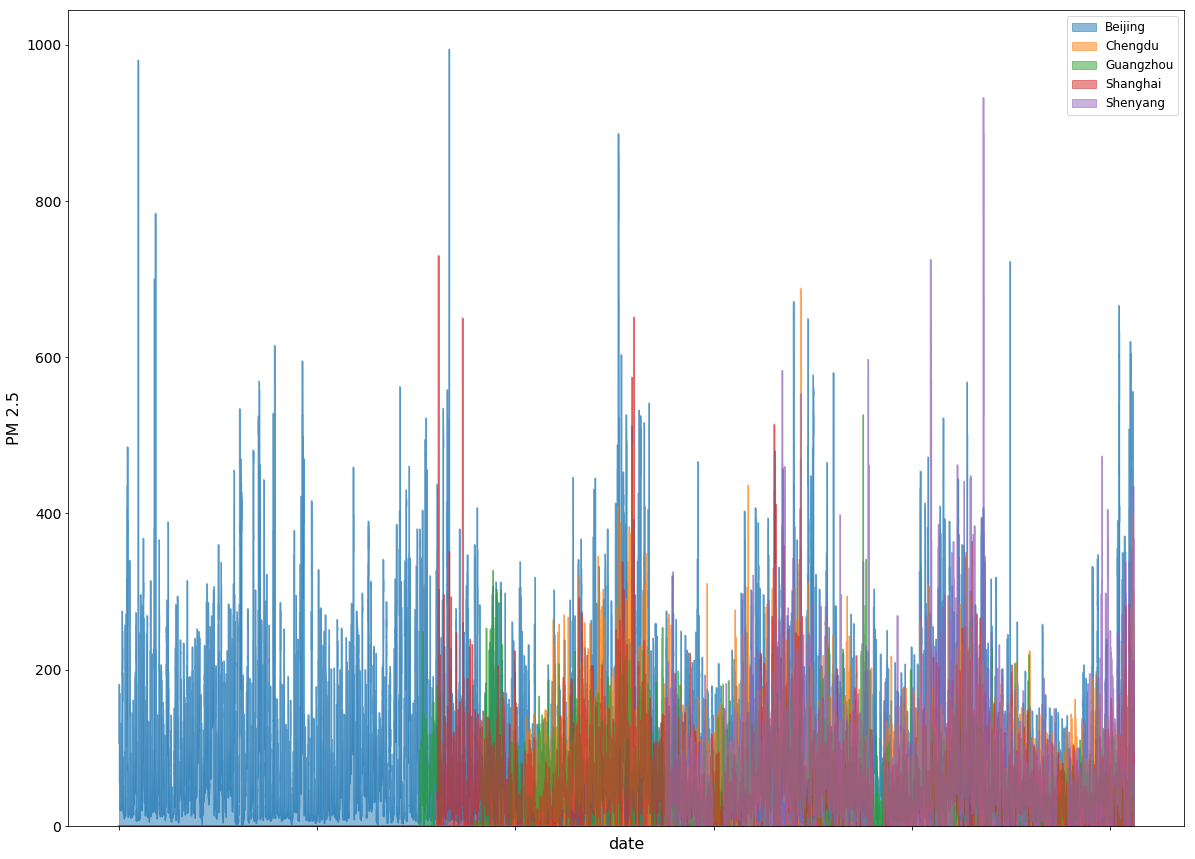

In [74]:

df.plot(kind='area',stacked=False,figsize=(20,15), alpha=0.5)
plt.legend()
plt.ylabel('PM 2.5')
plt.show()

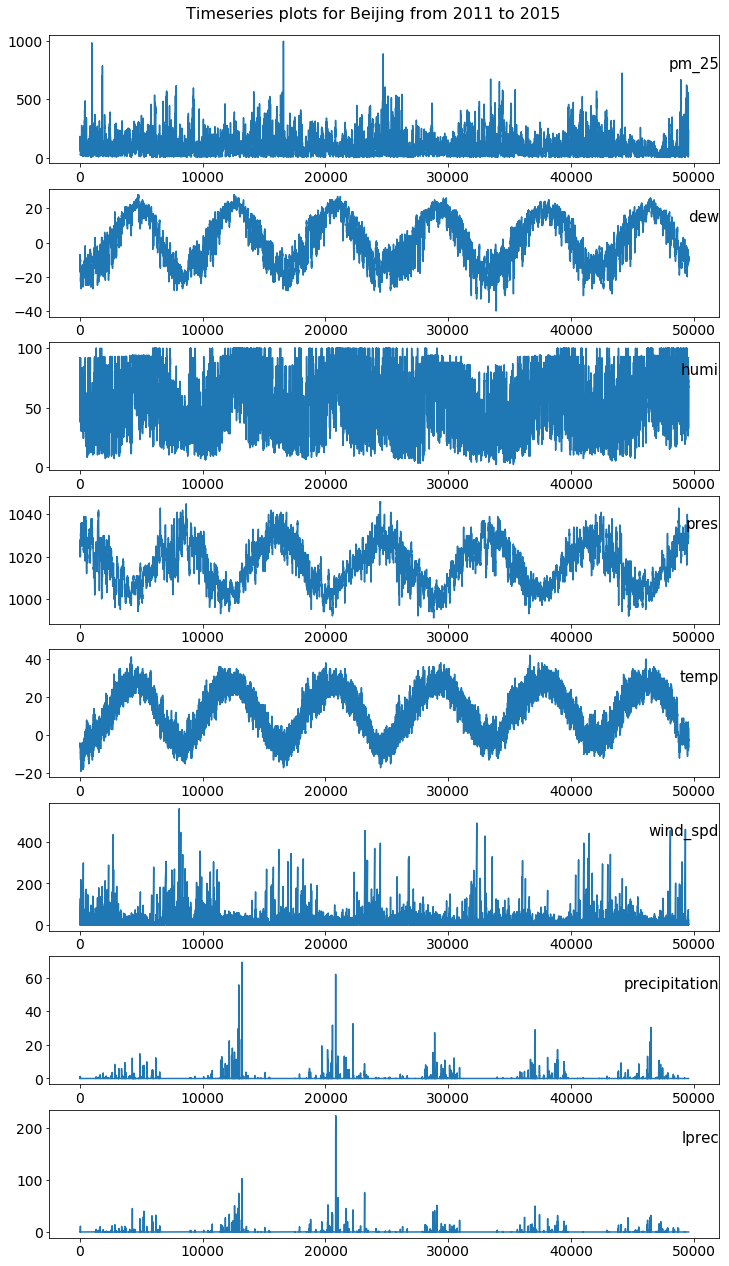

In [67]:
plotTimeseries('Beijing')

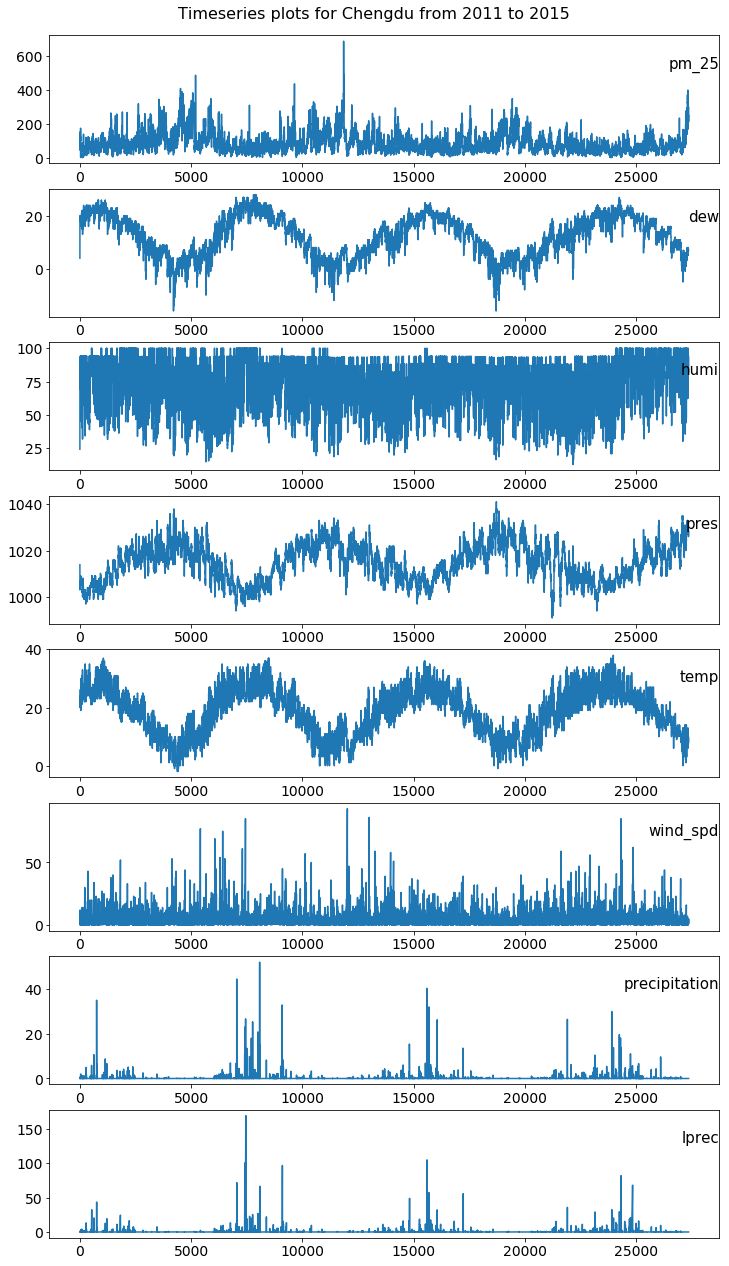

In [4]:
plotTimeseries('Chengdu')

In [5]:
# convert data to supervised learning
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


def train_test_split(data):
    n_train_hours = 365 * 24 * 2
    train = data[:n_train_hours, :]
    test = data[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return(train_X, train_y, test_X, test_y)

def train_model(city):
    dataset = load_dataset(city)
    values = dataset.values
    # integer encode wind direction
    encoder = LabelEncoder()
    values[:,5] = encoder.fit_transform(values[:,5])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = convert_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
    # design network
    
    model = Sequential()
    reframed_values = reframed.values
    train_X, train_y, test_X, test_y = train_test_split(reframed_values)
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=30, batch_size=72, 
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # plot history
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title(f'Loss function of model training for {city}')
    plt.legend()
    plt.show()

    # make a prediction
    y_pred = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_y_pred = concatenate((y_pred, test_X[:, 1:]), axis=1)
    inv_y_pred = scaler.inverse_transform(inv_y_pred)
    inv_y_pred = inv_y_pred[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_y_pred))
    print('Test RMSE: %.3f' % rmse)
    
    # plot predicted and observed PM2.5
    plt.figure(figsize=(10,8))
    plt.plot(inv_y, label='observed')
    plt.plot(inv_y_pred, label='predicted')
    plt.legend()
    plt.show()
    
    # save to csv file
    n_train_hours = 365 * 24 * 2
    new_index = dataset.index.values[n_train_hours+1: ]
    observed = inv_y
    
    predicted = inv_y_pred
    test_df = pd.DataFrame({'date':new_index, 'observed':observed, 'predicted':predicted}).set_index('date')
    predict_path = os.path.join('predictedData/', 'predicted_'+str(city)+'.csv')
    test_df.to_csv(predict_path)
    
    return rmse 


Train on 17520 samples, validate on 32058 samples
Epoch 1/30
 - 2s - loss: 0.0448 - val_loss: 0.0536
Epoch 2/30
 - 2s - loss: 0.0236 - val_loss: 0.0354
Epoch 3/30
 - 1s - loss: 0.0154 - val_loss: 0.0212
Epoch 4/30
 - 1s - loss: 0.0145 - val_loss: 0.0181
Epoch 5/30
 - 1s - loss: 0.0144 - val_loss: 0.0170
Epoch 6/30
 - 1s - loss: 0.0144 - val_loss: 0.0161
Epoch 7/30
 - 1s - loss: 0.0144 - val_loss: 0.0152
Epoch 8/30
 - 1s - loss: 0.0144 - val_loss: 0.0147
Epoch 9/30
 - 1s - loss: 0.0144 - val_loss: 0.0138
Epoch 10/30
 - 1s - loss: 0.0144 - val_loss: 0.0138
Epoch 11/30
 - 1s - loss: 0.0144 - val_loss: 0.0137
Epoch 12/30
 - 1s - loss: 0.0144 - val_loss: 0.0137
Epoch 13/30
 - 1s - loss: 0.0144 - val_loss: 0.0137
Epoch 14/30
 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 15/30
 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 16/30
 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 17/30
 - 1s - loss: 0.0144 - val_loss: 0.0134
Epoch 18/30
 - 1s - loss: 0.0144 - val_loss: 0.0136
Epoch 19/30
 - 2s - los

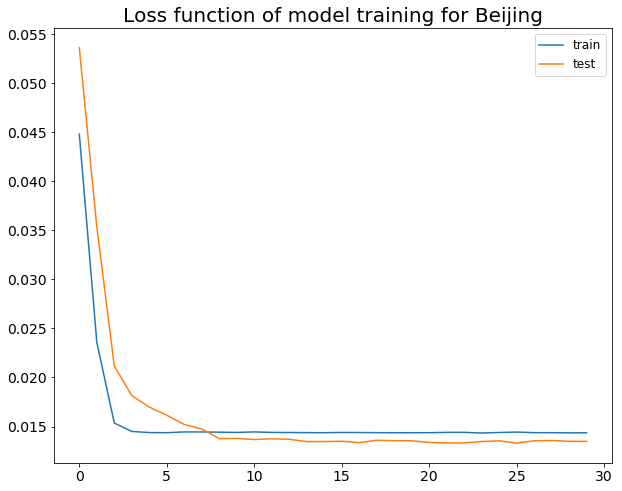

Test RMSE: 23.493


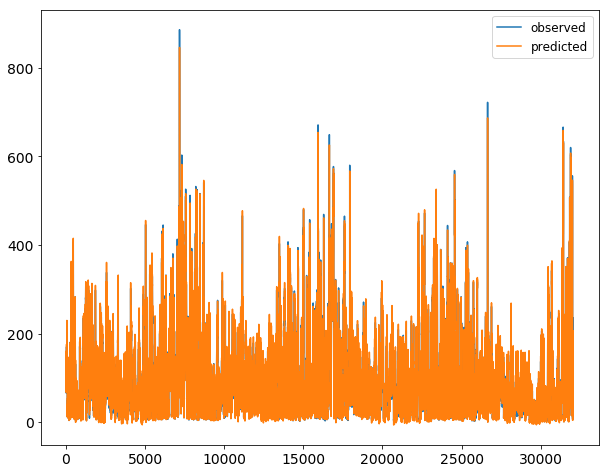

23.49278635543659

In [6]:
train_model('Beijing')

Train on 17520 samples, validate on 9847 samples
Epoch 1/30
 - 2s - loss: 0.0485 - val_loss: 0.0376
Epoch 2/30
 - 1s - loss: 0.0333 - val_loss: 0.0359
Epoch 3/30
 - 1s - loss: 0.0234 - val_loss: 0.0230
Epoch 4/30
 - 1s - loss: 0.0175 - val_loss: 0.0143
Epoch 5/30
 - 1s - loss: 0.0161 - val_loss: 0.0132
Epoch 6/30
 - 1s - loss: 0.0160 - val_loss: 0.0130
Epoch 7/30
 - 1s - loss: 0.0159 - val_loss: 0.0130
Epoch 8/30
 - 1s - loss: 0.0160 - val_loss: 0.0131
Epoch 9/30
 - 1s - loss: 0.0160 - val_loss: 0.0131
Epoch 10/30
 - 1s - loss: 0.0160 - val_loss: 0.0131
Epoch 11/30
 - 1s - loss: 0.0160 - val_loss: 0.0129
Epoch 12/30
 - 1s - loss: 0.0159 - val_loss: 0.0130
Epoch 13/30
 - 1s - loss: 0.0160 - val_loss: 0.0129
Epoch 14/30
 - 1s - loss: 0.0159 - val_loss: 0.0130
Epoch 15/30
 - 1s - loss: 0.0159 - val_loss: 0.0129
Epoch 16/30
 - 1s - loss: 0.0160 - val_loss: 0.0129
Epoch 17/30
 - 1s - loss: 0.0159 - val_loss: 0.0132
Epoch 18/30
 - 1s - loss: 0.0159 - val_loss: 0.0132
Epoch 19/30
 - 1s - loss

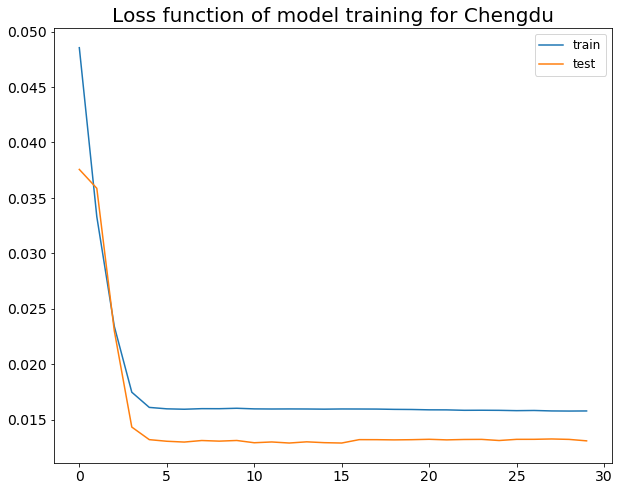

Test RMSE: 12.766


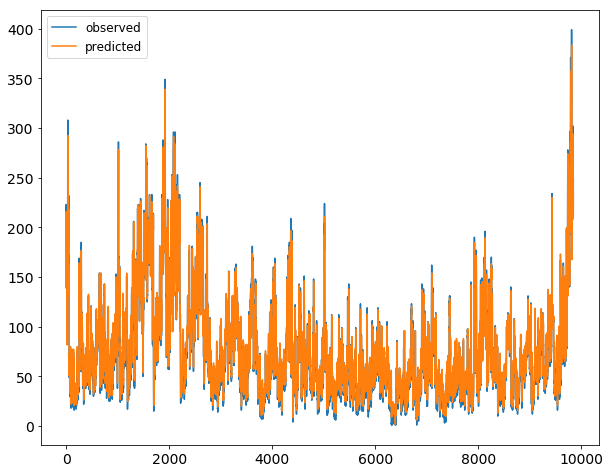

12.765653687238268

In [7]:
train_model('Chengdu')

Train on 17520 samples, validate on 14359 samples
Epoch 1/30
 - 2s - loss: 0.0358 - val_loss: 0.0396
Epoch 2/30
 - 1s - loss: 0.0210 - val_loss: 0.0157
Epoch 3/30
 - 1s - loss: 0.0129 - val_loss: 0.0097
Epoch 4/30
 - 1s - loss: 0.0112 - val_loss: 0.0096
Epoch 5/30
 - 1s - loss: 0.0111 - val_loss: 0.0095
Epoch 6/30
 - 1s - loss: 0.0111 - val_loss: 0.0095
Epoch 7/30
 - 1s - loss: 0.0110 - val_loss: 0.0095
Epoch 8/30
 - 1s - loss: 0.0110 - val_loss: 0.0096
Epoch 9/30
 - 1s - loss: 0.0111 - val_loss: 0.0097
Epoch 10/30
 - 1s - loss: 0.0110 - val_loss: 0.0095
Epoch 11/30
 - 1s - loss: 0.0110 - val_loss: 0.0097
Epoch 12/30
 - 1s - loss: 0.0111 - val_loss: 0.0096
Epoch 13/30
 - 1s - loss: 0.0110 - val_loss: 0.0098
Epoch 14/30
 - 1s - loss: 0.0110 - val_loss: 0.0097
Epoch 15/30
 - 1s - loss: 0.0110 - val_loss: 0.0096
Epoch 16/30
 - 1s - loss: 0.0110 - val_loss: 0.0097
Epoch 17/30
 - 1s - loss: 0.0110 - val_loss: 0.0098
Epoch 18/30
 - 1s - loss: 0.0110 - val_loss: 0.0098
Epoch 19/30
 - 1s - los

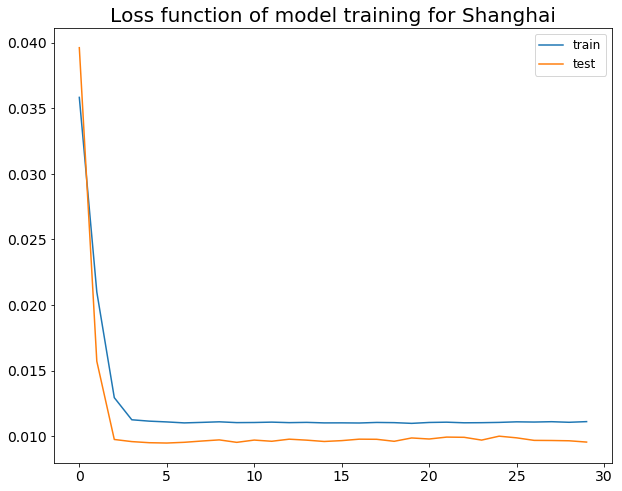

Test RMSE: 10.864


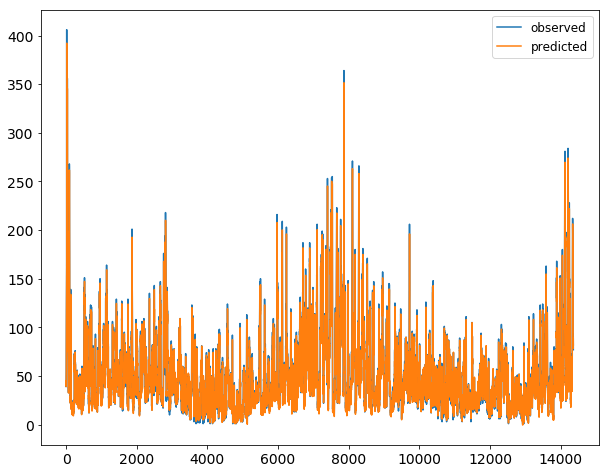

10.864168582849864

In [8]:
train_model('Shanghai')

Train on 17520 samples, validate on 14826 samples
Epoch 1/30
 - 2s - loss: 0.0535 - val_loss: 0.0306
Epoch 2/30
 - 1s - loss: 0.0361 - val_loss: 0.0179
Epoch 3/30
 - 1s - loss: 0.0219 - val_loss: 0.0168
Epoch 4/30
 - 1s - loss: 0.0167 - val_loss: 0.0148
Epoch 5/30
 - 1s - loss: 0.0164 - val_loss: 0.0138
Epoch 6/30
 - 1s - loss: 0.0165 - val_loss: 0.0135
Epoch 7/30
 - 1s - loss: 0.0164 - val_loss: 0.0135
Epoch 8/30
 - 1s - loss: 0.0164 - val_loss: 0.0132
Epoch 9/30
 - 1s - loss: 0.0164 - val_loss: 0.0132
Epoch 10/30
 - 1s - loss: 0.0163 - val_loss: 0.0136
Epoch 11/30
 - 1s - loss: 0.0163 - val_loss: 0.0132
Epoch 12/30
 - 1s - loss: 0.0163 - val_loss: 0.0130
Epoch 13/30
 - 1s - loss: 0.0163 - val_loss: 0.0129
Epoch 14/30
 - 1s - loss: 0.0163 - val_loss: 0.0129
Epoch 15/30
 - 1s - loss: 0.0163 - val_loss: 0.0128
Epoch 16/30
 - 1s - loss: 0.0163 - val_loss: 0.0131
Epoch 17/30
 - 1s - loss: 0.0164 - val_loss: 0.0128
Epoch 18/30
 - 1s - loss: 0.0163 - val_loss: 0.0130
Epoch 19/30
 - 1s - los

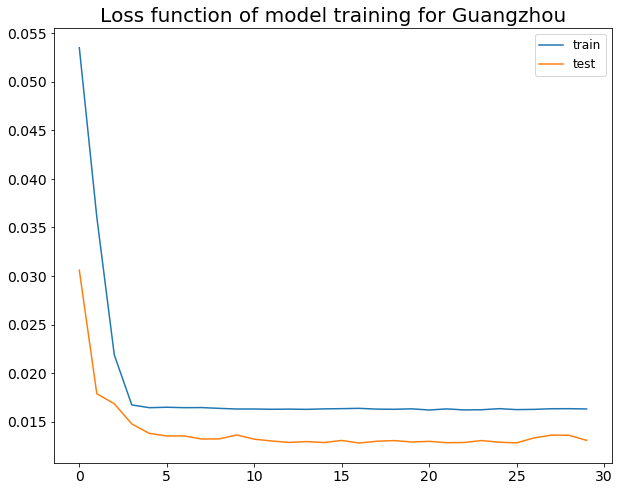

Test RMSE: 11.819


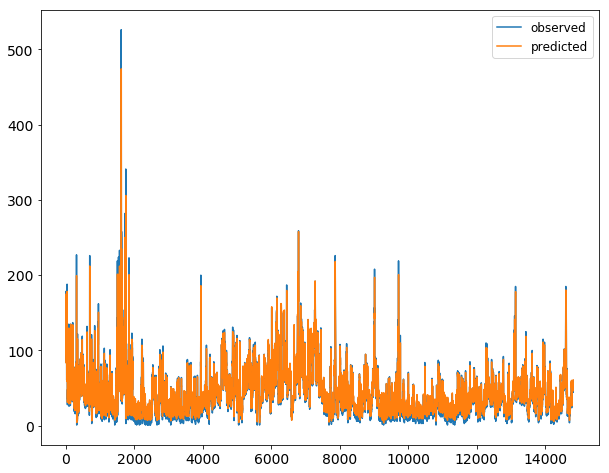

11.81897505652325

In [9]:
train_model('Guangzhou')

Train on 17520 samples, validate on 2931 samples
Epoch 1/30
 - 2s - loss: 0.0351 - val_loss: 0.0408
Epoch 2/30
 - 1s - loss: 0.0233 - val_loss: 0.0224
Epoch 3/30
 - 1s - loss: 0.0161 - val_loss: 0.0143
Epoch 4/30
 - 1s - loss: 0.0151 - val_loss: 0.0138
Epoch 5/30
 - 1s - loss: 0.0149 - val_loss: 0.0137
Epoch 6/30
 - 1s - loss: 0.0149 - val_loss: 0.0138
Epoch 7/30
 - 1s - loss: 0.0149 - val_loss: 0.0140
Epoch 8/30
 - 1s - loss: 0.0149 - val_loss: 0.0139
Epoch 9/30
 - 1s - loss: 0.0149 - val_loss: 0.0142
Epoch 10/30
 - 1s - loss: 0.0149 - val_loss: 0.0144
Epoch 11/30
 - 1s - loss: 0.0149 - val_loss: 0.0142
Epoch 12/30
 - 1s - loss: 0.0149 - val_loss: 0.0142
Epoch 13/30
 - 1s - loss: 0.0149 - val_loss: 0.0143
Epoch 14/30
 - 1s - loss: 0.0149 - val_loss: 0.0147
Epoch 15/30
 - 1s - loss: 0.0149 - val_loss: 0.0145
Epoch 16/30
 - 1s - loss: 0.0149 - val_loss: 0.0140
Epoch 17/30
 - 1s - loss: 0.0148 - val_loss: 0.0150
Epoch 18/30
 - 1s - loss: 0.0149 - val_loss: 0.0144
Epoch 19/30
 - 1s - loss

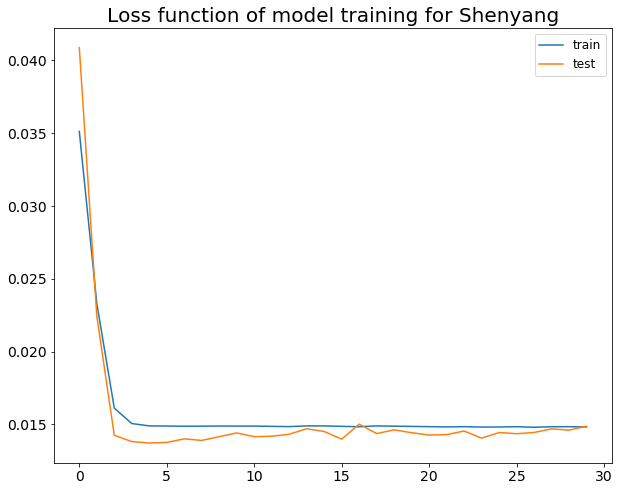

Test RMSE: 21.067


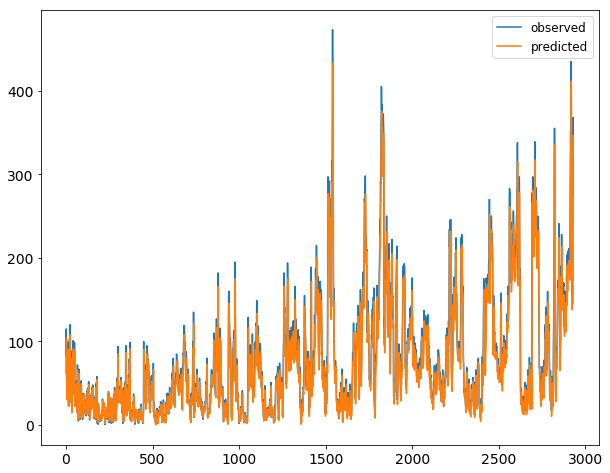

21.066902764522453

In [10]:
train_model('Shenyang')